In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.9,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_09_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:53 - loss: 0.1558 - STD: 2.3233e-04 - MAE: 0.3815

 16/632 [..............................] - ETA: 2s - loss: 0.0353 - STD: 2.1553e-04 - MAE: 0.1367   

 31/632 [>.............................] - ETA: 2s - loss: 0.0255 - STD: 1.5928e-04 - MAE: 0.1144

 47/632 [=>............................] - ETA: 1s - loss: 0.0213 - STD: 1.4418e-04 - MAE: 0.0988

 63/632 [=>............................] - ETA: 1s - loss: 0.0191 - STD: 1.5448e-04 - MAE: 0.0912

 78/632 [==>...........................] - ETA: 1s - loss: 0.0178 - STD: 1.8579e-04 - MAE: 0.0872

 94/632 [===>..........................] - ETA: 1s - loss: 0.0169 - STD: 2.5737e-04 - MAE: 0.0840

110/632 [====>.........................] - ETA: 1s - loss: 0.0163 - STD: 4.2770e-04 - MAE: 0.0821

125/632 [====>.........................] - ETA: 1s - loss: 0.0157 - STD: 8.3442e-04 - MAE: 0.0803

141/632 [=====>........................] - ETA: 1s - loss: 0.0152 - STD: 0.0021 - MAE: 0.0785    

158/632 [======>.......................] - ETA: 2s - loss: 0.0144 - STD: 0.0058 - MAE: 0.0757

173/632 [=======>......................] - ETA: 2s - loss: 0.0135 - STD: 0.0115 - MAE: 0.0726

189/632 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 0.0181 - MAE: 0.0695

205/632 [========>.....................] - ETA: 2s - loss: 0.0119 - STD: 0.0241 - MAE: 0.0668

222/632 [=========>....................] - ETA: 2s - loss: 0.0112 - STD: 0.0297 - MAE: 0.0643

239/632 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 0.0347 - MAE: 0.0621

256/632 [===========>..................] - ETA: 1s - loss: 0.0100 - STD: 0.0390 - MAE: 0.0601

273/632 [===========>..................] - ETA: 1s - loss: 0.0095 - STD: 0.0429 - MAE: 0.0584

290/632 [============>.................] - ETA: 1s - loss: 0.0091 - STD: 0.0461 - MAE: 0.0567

307/632 [=============>................] - ETA: 1s - loss: 0.0087 - STD: 0.0494 - MAE: 0.0553

323/632 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.0520 - MAE: 0.0540

339/632 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.0545 - MAE: 0.0528

355/632 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.0567 - MAE: 0.0517

372/632 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0589 - MAE: 0.0507

388/632 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0608 - MAE: 0.0498

404/632 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.0624 - MAE: 0.0489

421/632 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0641 - MAE: 0.0481

438/632 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0657 - MAE: 0.0474

455/632 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0672 - MAE: 0.0467

472/632 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0685 - MAE: 0.0460

489/632 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0697 - MAE: 0.0454

505/632 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0708 - MAE: 0.0448

520/632 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0718 - MAE: 0.0443

536/632 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0728 - MAE: 0.0438

554/632 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0738 - MAE: 0.0433

570/632 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0429

587/632 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0755 - MAE: 0.0424

603/632 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0763 - MAE: 0.0420

620/632 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0416

632/632 [==============================] - 4s 5ms/step - loss: 0.0051 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0019 - val_STD: 0.0782 - val_MAE: 0.0303


Epoch 2/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0267

 16/632 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0277 

 32/632 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

 46/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

 59/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

 72/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0273

 85/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0271

 98/632 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0271

110/632 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

122/632 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

136/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

152/632 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

168/632 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

182/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

200/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

217/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

234/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

250/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

266/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

282/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

298/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

314/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

330/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

347/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

364/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

380/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

396/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

413/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

431/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

448/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

466/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

483/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

500/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

517/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

534/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

551/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

568/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

586/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

603/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

620/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270 - val_loss: 0.0016 - val_STD: 0.0796 - val_MAE: 0.0281


Epoch 3/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262 

 28/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0263

 41/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

 56/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

 71/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0269

 86/632 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

 99/632 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

112/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

128/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

145/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

162/632 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

179/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

197/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

214/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

231/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

244/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

257/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

271/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

287/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

305/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

324/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

342/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

360/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

378/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

394/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

411/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

428/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

444/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

462/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

478/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

490/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

505/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

517/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

534/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

551/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

566/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

584/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

602/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

618/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

632/632 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0015 - val_STD: 0.0808 - val_MAE: 0.0275


Epoch 4/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0253

 16/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0256 

 31/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

 46/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0259

 61/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0257

 75/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

 88/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

101/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

114/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

126/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

138/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

151/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

163/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

176/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

189/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

201/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

214/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

226/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

239/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

251/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

263/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

276/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

289/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

303/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

316/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

330/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

343/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

356/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

370/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

382/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

394/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

407/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

421/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

433/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

446/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

459/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

474/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

487/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

500/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

517/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

534/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

551/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

564/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

577/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

590/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

603/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

616/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

630/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

632/632 [==============================] - 3s 4ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259 - val_loss: 0.0015 - val_STD: 0.0801 - val_MAE: 0.0270


Epoch 5/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.0940 - MAE: 0.0238

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0257 

 27/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

 39/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

 53/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1051 - MAE: 0.0252

 65/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

 77/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

 90/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

104/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

117/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

130/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

143/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

156/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

171/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

185/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

199/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

213/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

227/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

240/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

256/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

270/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

286/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

303/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

320/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

337/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

354/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

372/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

388/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

404/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

420/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

435/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

448/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

461/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

473/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

486/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

499/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

514/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

526/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

539/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

554/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

571/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

587/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

604/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

621/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256 - val_loss: 0.0016 - val_STD: 0.0823 - val_MAE: 0.0276


Epoch 6/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0247

 17/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247 

 33/632 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0247

 50/632 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

 66/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

 82/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

 98/632 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

113/632 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

130/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

147/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

163/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

180/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

197/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

213/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

229/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

246/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

264/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

281/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

297/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

314/632 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

331/632 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

347/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

363/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

380/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

397/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

413/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

430/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

448/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

467/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

484/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

501/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

518/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

532/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

548/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

563/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

578/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

593/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

606/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

621/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

632/632 [==============================] - 2s 3ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250 - val_loss: 0.0014 - val_STD: 0.0819 - val_MAE: 0.0262


Epoch 7/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0237

 15/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1079 - MAE: 0.0247 

 29/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

 43/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0245

 56/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

 69/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0245

 82/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0247

 96/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

109/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

121/632 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0247

135/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

151/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

165/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

178/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

192/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

206/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

219/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

233/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

248/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

266/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

279/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

291/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

304/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

317/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

330/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

342/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

355/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

367/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

381/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

393/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

405/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

418/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

434/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

448/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

461/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

476/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

493/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

507/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

521/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

534/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

546/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

559/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

574/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

588/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

606/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

620/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

632/632 [==============================] - 3s 4ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246 - val_loss: 0.0014 - val_STD: 0.0828 - val_MAE: 0.0259


Epoch 8/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1138 - MAE: 0.0245

 15/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0238 

 30/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

 45/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

 62/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0240

 80/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

 98/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0244

116/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0245

134/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0245

151/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0245

169/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0245

187/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0245

203/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

219/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

236/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

254/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

271/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

288/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

305/632 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

317/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

331/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

348/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

365/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0245

382/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

399/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

415/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

431/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

448/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

464/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

481/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

499/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

517/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

533/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

549/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

566/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

583/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

601/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

617/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

632/632 [==============================] - 2s 3ms/step - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243 - val_loss: 0.0016 - val_STD: 0.0848 - val_MAE: 0.0273


Epoch 9/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0238

 16/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1080 - MAE: 0.0240 

 32/632 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

 48/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0240

 65/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0239

 81/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0239

 98/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0238

114/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0238

129/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0238

146/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0240

160/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0240

176/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

194/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0240

212/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

230/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

247/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

264/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

281/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

298/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

315/632 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

333/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

351/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

369/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

387/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

406/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

424/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

441/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

459/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

476/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

493/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

511/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

528/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

545/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

561/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

579/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

596/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

613/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

630/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

632/632 [==============================] - 2s 3ms/step - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239 - val_loss: 0.0017 - val_STD: 0.0873 - val_MAE: 0.0276


Epoch 10/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

 15/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1050 - MAE: 0.0241 

 34/632 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0237

 52/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0238

 70/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0237

 88/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0237

106/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0236

124/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0236

142/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0236

160/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0236

177/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0236

195/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0235

212/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0236

229/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0236

245/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0237

258/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

275/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0236

292/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0236

310/632 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

328/632 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

346/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

362/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

379/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

396/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

411/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

426/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

442/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

459/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

476/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

494/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

512/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

529/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

544/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

561/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

577/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

592/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

608/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

625/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

632/632 [==============================] - 2s 3ms/step - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236 - val_loss: 0.0018 - val_STD: 0.0880 - val_MAE: 0.0282


Epoch 11/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0011 - STD: 0.1235 - MAE: 0.0237

 14/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1104 - MAE: 0.0234 

 28/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0230

 46/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0232

 64/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

 82/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

 99/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

117/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

134/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

152/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

168/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0233

185/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0233

202/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0233

220/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0233

237/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0233

254/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0233

271/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0234

287/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0233

303/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0233

320/632 [==============>...............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0234

337/632 [==============>...............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0234

354/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0234

371/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0234

388/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0234

405/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

422/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

439/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

457/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

475/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

493/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

511/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

529/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

547/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

565/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

583/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

601/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

619/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

632/632 [==============================] - 2s 3ms/step - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233 - val_loss: 0.0016 - val_STD: 0.0848 - val_MAE: 0.0268


Epoch 12/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0227

 18/632 [..............................] - ETA: 1s - loss: 0.0011 - STD: 0.1083 - MAE: 0.0233 

 36/632 [>.............................] - ETA: 1s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0230

 54/632 [=>............................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0229

 71/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

 87/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0229

104/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0229

121/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

139/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

156/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

173/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0230

190/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0230

207/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0230

223/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0230

239/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0230

255/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0231

271/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

288/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

305/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0231

322/632 [==============>...............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

338/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

355/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

372/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0230

390/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

406/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

423/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

440/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

458/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

475/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

492/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

508/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

524/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

540/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

556/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

572/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

588/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

604/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

620/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

632/632 [==============================] - 2s 3ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231 - val_loss: 0.0018 - val_STD: 0.0878 - val_MAE: 0.0283


Epoch 13/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0011 - STD: 0.1097 - MAE: 0.0234

 16/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1095 - MAE: 0.0229 

 31/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1093 - MAE: 0.0227

 49/632 [=>............................] - ETA: 1s - loss: 0.0010 - STD: 0.1088 - MAE: 0.0226

 67/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1089 - MAE: 0.0227

 80/632 [==>...........................] - ETA: 1s - loss: 0.0011 - STD: 0.1082 - MAE: 0.0227

 92/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1083 - MAE: 0.0227

106/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1084 - MAE: 0.0228

122/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1083 - MAE: 0.0228

140/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0228

158/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

176/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

194/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

211/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

228/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

245/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0228

262/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

278/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

295/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

311/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

328/632 [==============>...............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

345/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

361/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

377/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

394/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

411/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

428/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

446/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

463/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

480/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

497/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

516/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

535/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

553/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

570/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

587/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

605/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

622/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

632/632 [==============================] - 2s 3ms/step - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227 - val_loss: 0.0019 - val_STD: 0.0873 - val_MAE: 0.0285


Epoch 14/10000


  1/632 [..............................] - ETA: 16s - loss: 8.0667e-04 - STD: 0.1155 - MAE: 0.0205

 14/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1091 - MAE: 0.0225     

 29/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1074 - MAE: 0.0225

 45/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

 58/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

 71/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0225

 84/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

 97/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0225

110/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0225

126/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0226

144/632 [=====>........................] - ETA: 1s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0226

159/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0227

171/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0227

184/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0227

201/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

214/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0227

227/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0227

239/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0227

252/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

265/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

277/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

291/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

307/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

324/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

340/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0227

351/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0227

364/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0226

382/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0226

399/632 [=================>............] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

412/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

426/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

438/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

451/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

467/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

481/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

498/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

515/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

532/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

550/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

567/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

585/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

602/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

619/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

632/632 [==============================] - 2s 4ms/step - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226 - val_loss: 0.0017 - val_STD: 0.0850 - val_MAE: 0.0277


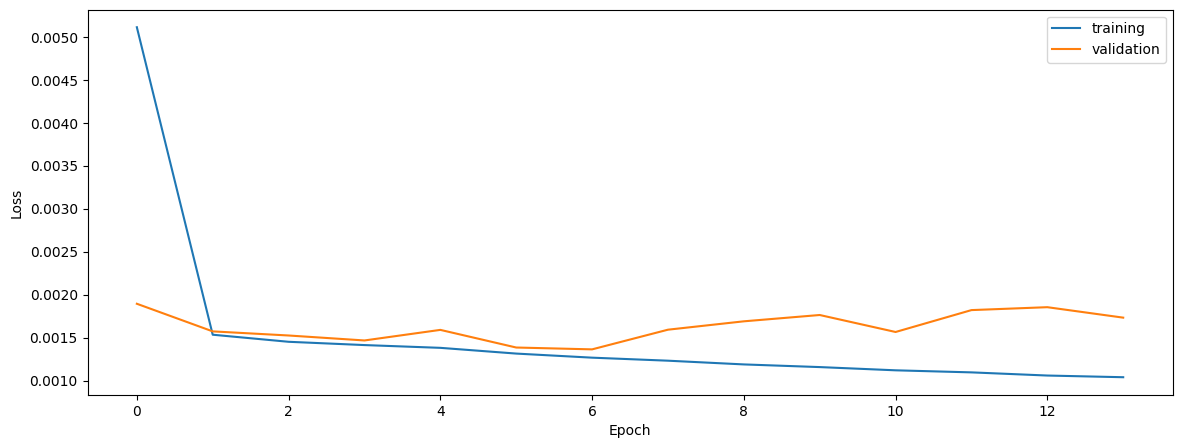

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9516572989439523
0.9600193870842562
0.9488050492785831


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9516572989439523
0.9600193870842562
0.9488050492785831


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9574109096675171
0.9622860963884875
0.9600931214377688


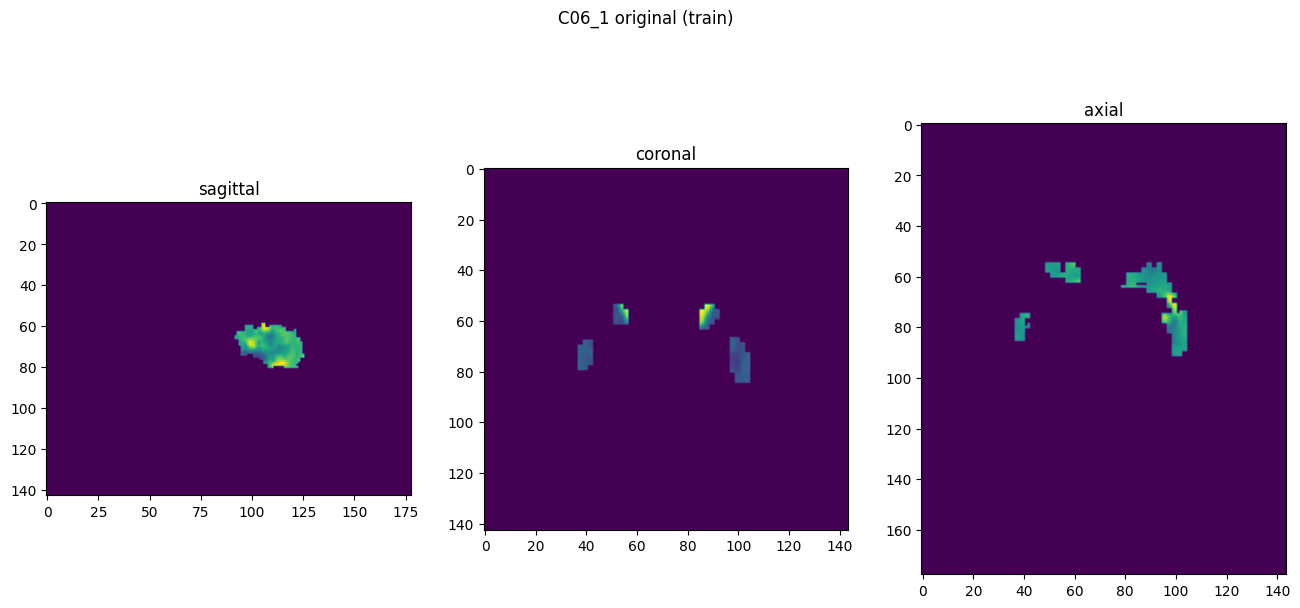

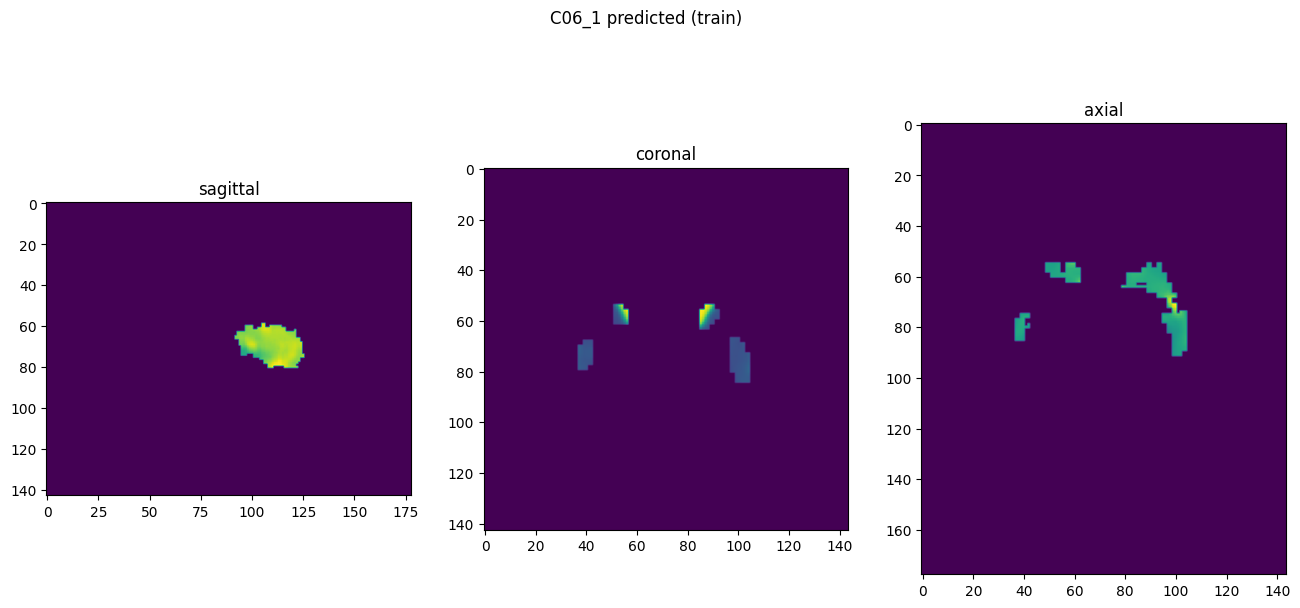

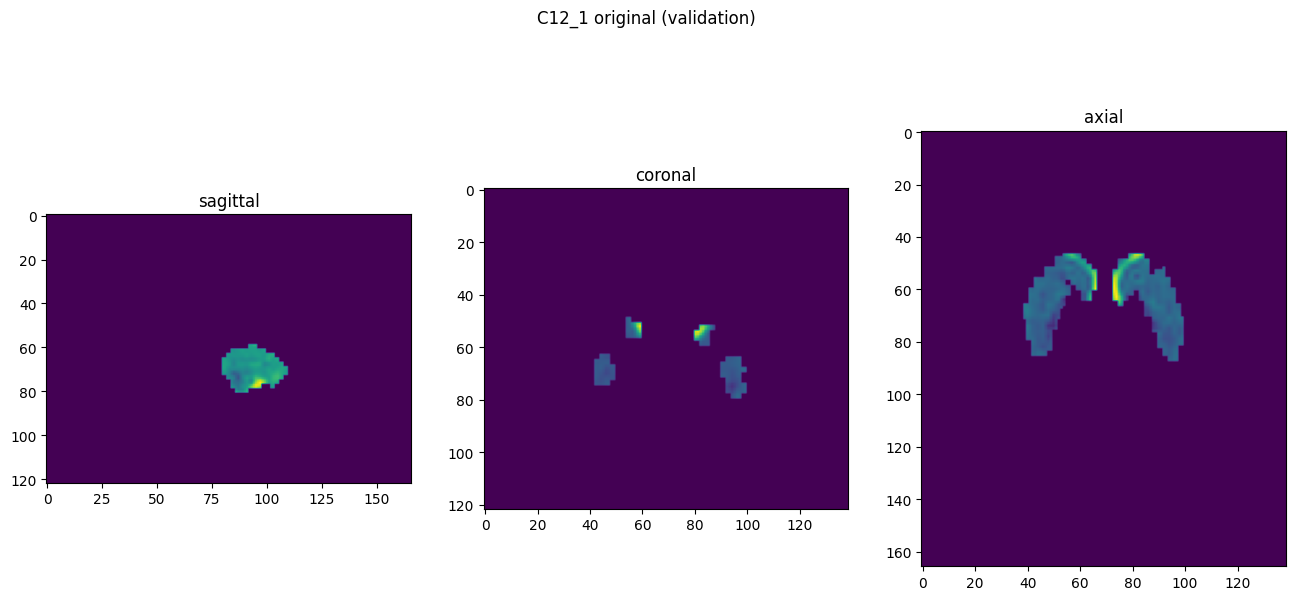

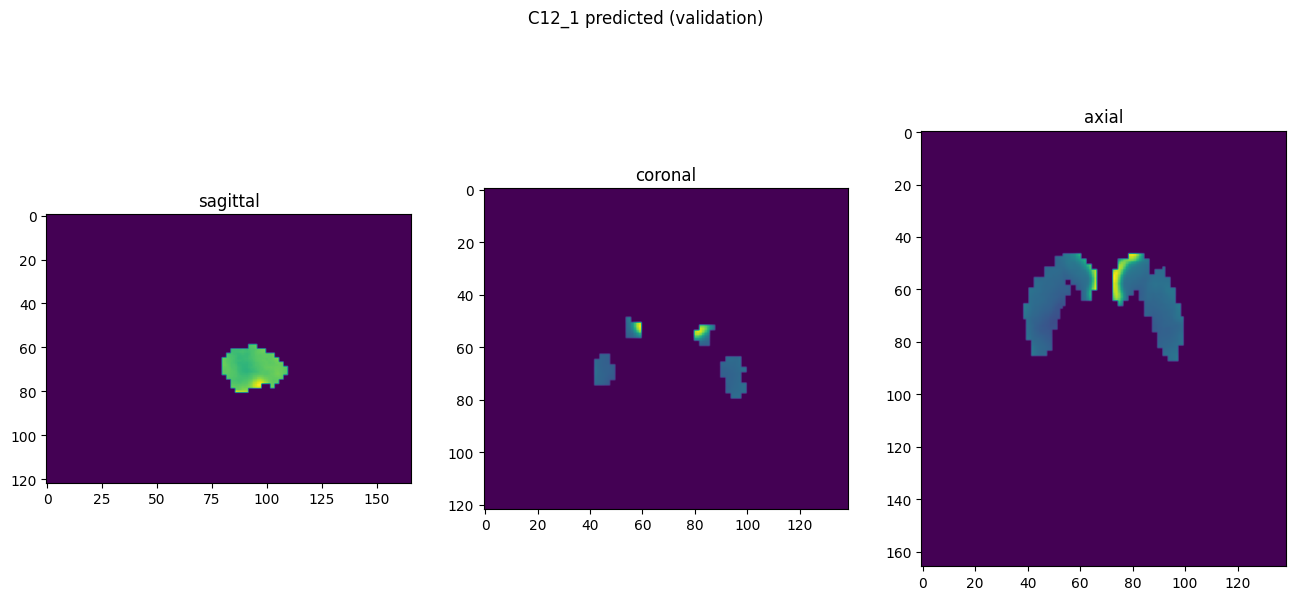

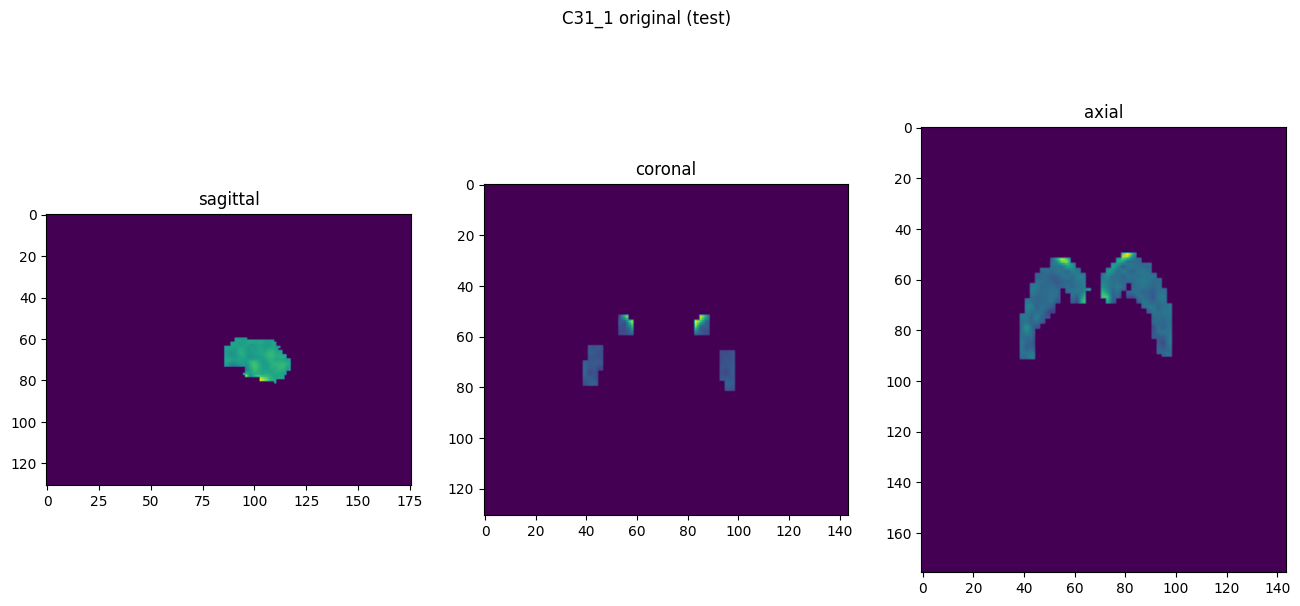

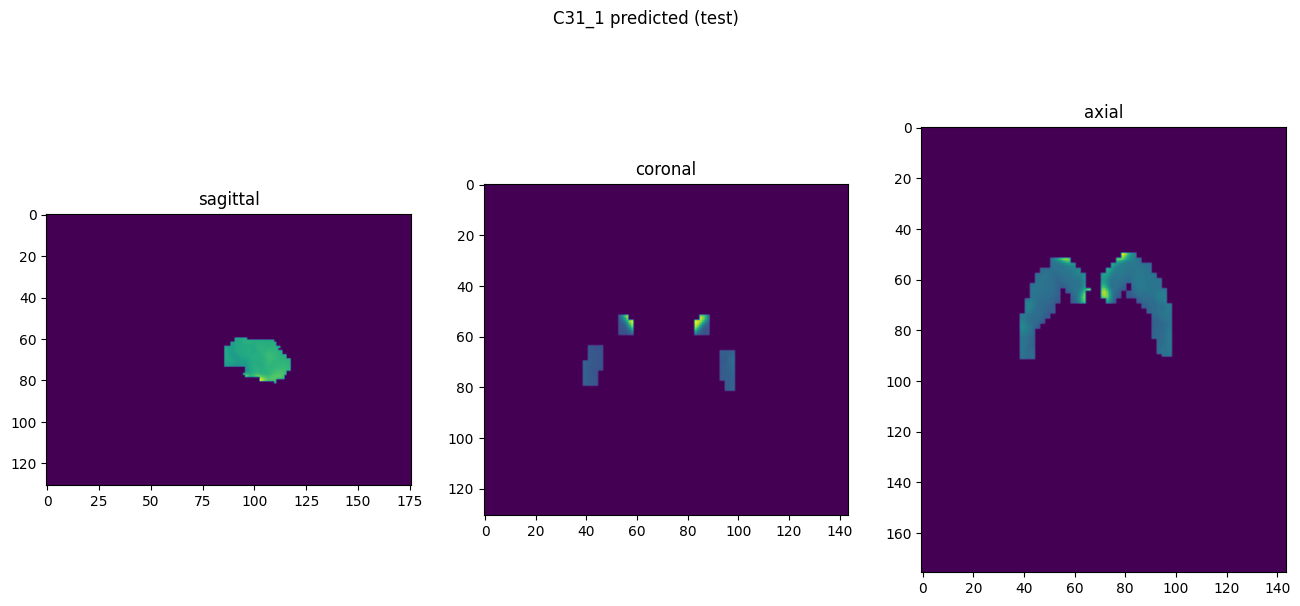

In [10]:
showResults(model, gen, threshold=None, background=False)